In [10]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from models import utils
from models import arx



In [11]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Constants
NA = 4
NB = 5
ALPHA = 10e6

In [13]:
data1 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex2_handout/ex2_system1_data.mat")
data2 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex2_handout/ex2_system2_data.mat")

display(data1.keys())
display(data2.keys())

t = data1.t1
Ts = t[1] - t[0]


dict_keys(['__header__', '__version__', '__globals__', 'README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

dict_keys(['__header__', '__version__', '__globals__', 'README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

In [14]:
def create_plt(p_hat, k:int):
    Gest = tf(p_hat[NA:], [1] + [-p_hat[i] for i in range(NB)], Ts)
    t = data1.get("t1")
    u = data1.get("u1")
    y = data1.get("y1")
    y_test,_ , t_test = lsim(Gest, u, t)
    plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 5))
    plt.plot(t,y, label="System Response")
    plt.xlabel("Time [s]")
    plt.plot(t, y_test,label="Model Response")
    plt.legend()
    plt.savefig(f"figures/ex2/IT{k}.png")

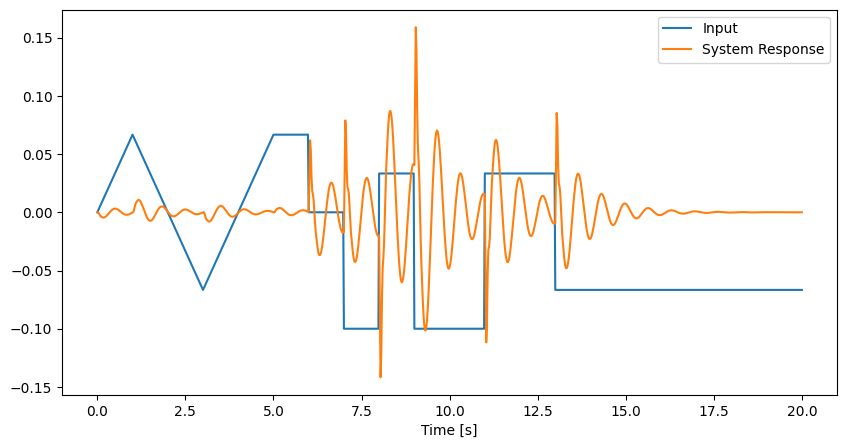

In [15]:
t = data1.t1
u = data1.u1
y = data1.y1
plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()


In [18]:
p_hat, loss, na, nb  = arx.optimize(data1.y1, data1.u1, (1,10),(1,10))

Testing 81 combinations.
Progress: 1.23 %
Current iteration: 1 / 81
Iteration took 0.33 seconds, average 0.17 seconds


In [20]:
y_val, u_test, t_val= data1.y2, data1.u2, data1.t2

y_test = arx.simulate(jnp.array([0]), u_test,na,nb, p_hat)

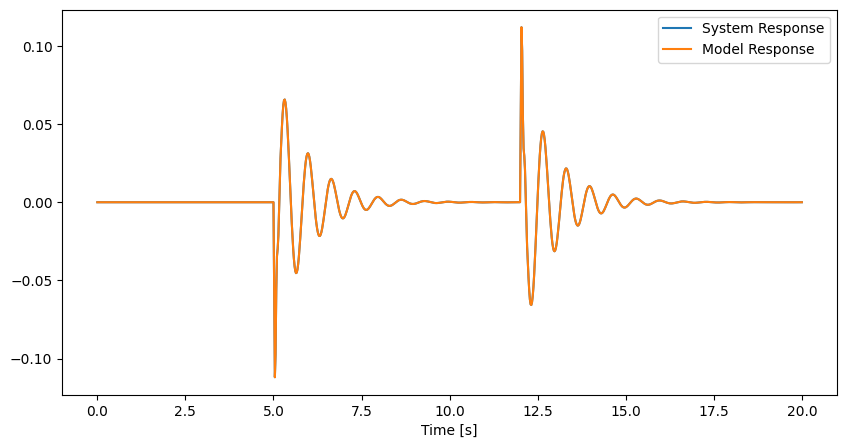

In [21]:

plt.figure(figsize=(10, 5))
plt.plot(t_val,y_val, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t_val, y_test,label="Model Response")
plt.legend()
plt.show()


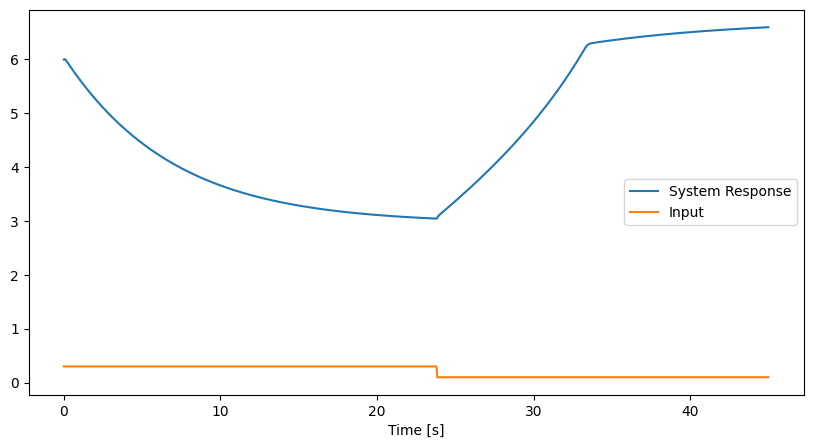

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(data2.t1, data2.y1, label="System Response")
plt.xlabel("Time [s]")
plt.plot(data2.t1, data2.u1,label="Input")
plt.legend()
plt.show()

In [24]:
p_hat, loss, na, nb  = arx.optimize(data2.y1, data2.u1, (1,10),(1,10))
y_val, u_test, t_val= data2.y2, data2.u2, data2.t2



Testing 81 combinations.
Progress: 1.23 %
Current iteration: 1 / 81
Iteration took 0.00 seconds, average 0.00 seconds


In [30]:
display(na,nb)

y_test = arx.simulate(jnp.array([0]), u_test,na,nb, p_hat)
y_train = arx.simulate(jnp.array([0]), data2.u1,na,nb, p_hat)


9

1

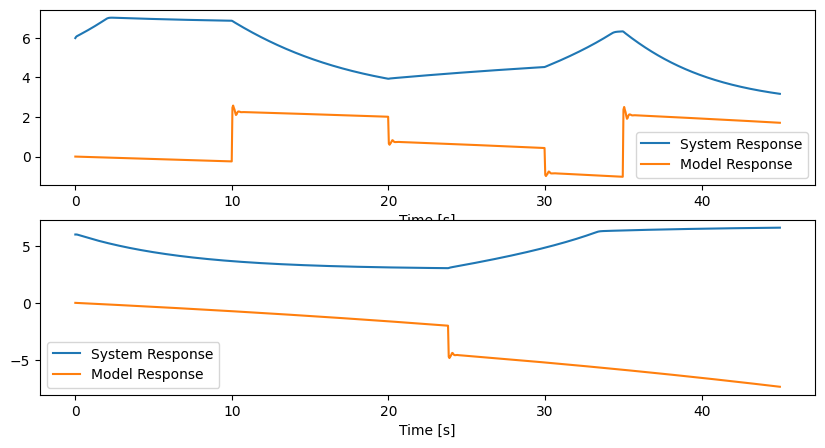

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(t_val,y_val, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t_val, y_test,label="Model Response")
plt.legend()

plt.subplot(2,1,2)
plt.plot(data2.t1,data2.y1, label="System Response")
plt.xlabel("Time [s]")
plt.plot(data2.t1, y_train,label="Model Response")
plt.legend()

plt.show()